In [1]:
!pip -q install scikit-learn joblib matplotlib pandas numpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)

import joblib

In [4]:
df = pd.read_csv("/content/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [5]:
df.shape

(184307, 31)

In [6]:
target_col = "Class"

print(df[target_col].value_counts())
print("\nFraud ratio:", df[target_col].mean())

Class
0.0    183939
1.0       367
Name: count, dtype: int64

Fraud ratio: 0.0019912536759519495


In [7]:
X = df.drop(columns=[target_col])
y = df[target_col]

id_like_cols = [c for c in X.columns if c.lower() in ["id", "transactionid", "txn_id"]]
if id_like_cols:
    print("Dropping ID-like columns:", id_like_cols)
    X = X.drop(columns=id_like_cols)

print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (184307, 30) | y shape: (184307,)


In [8]:
target_col = "Class"

print("Target dtype:", df[target_col].dtype)
print("NaNs in target:", df[target_col].isna().sum())
print(df[target_col].value_counts(dropna=False).head(10))

Target dtype: float64
NaNs in target: 1
Class
0.0    183939
1.0       367
NaN         1
Name: count, dtype: int64


In [9]:
df_clean = df.dropna(subset=[target_col]).copy()

df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors="coerce")

df_clean = df_clean.dropna(subset=[target_col]).copy()

df_clean[target_col] = df_clean[target_col].astype(int)

print("After cleaning:")
print("Shape:", df_clean.shape)
print("NaNs in target:", df_clean[target_col].isna().sum())
print(df_clean[target_col].value_counts())

After cleaning:
Shape: (184306, 31)
NaNs in target: 0
Class
0    183939
1       367
Name: count, dtype: int64


In [10]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]


num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
cat_cols = X.select_dtypes(exclude=[np.number]).columns
if len(cat_cols) > 0:
    X[cat_cols] = X[cat_cols].fillna("missing")

print("NaNs in X:", X.isna().sum().sum())
print("NaNs in y:", y.isna().sum())

NaNs in X: 0
NaNs in y: 0


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train fraud ratio:", y_train.mean())
print("Test fraud ratio :", y_test.mean())

Train fraud ratio: 0.0019939773744608123
Test fraud ratio : 0.0019803591774727363


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("=== Logistic Regression (Baseline) ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC (Avg Precision):", average_precision_score(y_test, y_proba_lr))

=== Logistic Regression (Baseline) ===
              precision    recall  f1-score   support

           0     0.9998    0.9799    0.9897     36789
           1     0.0819    0.9041    0.1502        73

    accuracy                         0.9797     36862
   macro avg     0.5408    0.9420    0.5700     36862
weighted avg     0.9980    0.9797    0.9881     36862

Confusion Matrix:
 [[36049   740]
 [    7    66]]
ROC-AUC: 0.9658893348480804
PR-AUC (Avg Precision): 0.6777432572842499


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC (Avg Precision):", average_precision_score(y_test, y_proba_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     36789
           1     0.9831    0.7945    0.8788        73

    accuracy                         0.9996     36862
   macro avg     0.9913    0.8972    0.9393     36862
weighted avg     0.9996    0.9996    0.9995     36862

Confusion Matrix:
 [[36788     1]
 [   15    58]]
ROC-AUC: 0.9368136768100351
PR-AUC (Avg Precision): 0.8481603480096194


In [14]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

def metrics_row(y_true, y_pred, name):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"model": name, "precision": p, "recall": r, "f1": f1}

summary = pd.DataFrame([
    metrics_row(y_test, y_pred_lr, "Logistic Regression"),
    metrics_row(y_test, y_pred_rf, "Random Forest"),
])

display(summary.sort_values("f1", ascending=False))

,model,precision,recall,f1
1,Random Forest,0.983051,0.794521,0.878788
0,Logistic Regression,0.081886,0.904110,0.150171


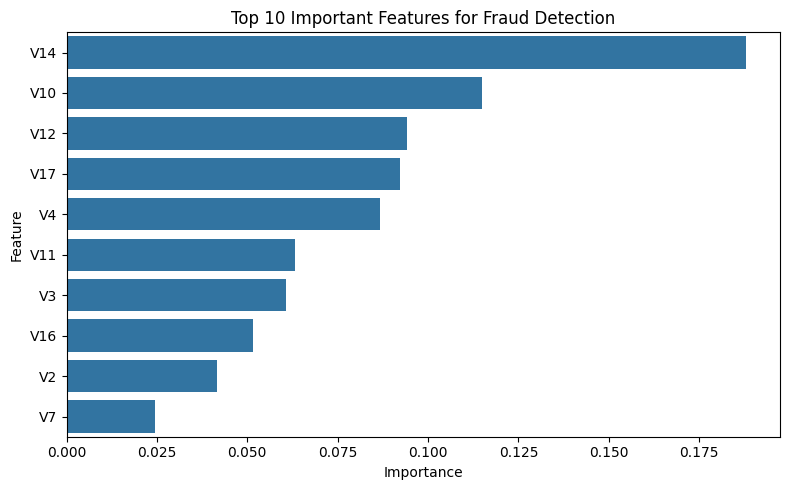

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

importances = rf.feature_importances_
features = X.columns

feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

feature_df


plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Top 10 Important Features for Fraud Detection")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [19]:
import joblib

best_name = summary.sort_values("f1", ascending=False).iloc[0]["model"]
best_model = rf if best_name == "Random Forest" else lr

MODEL_PATH = "best_fraud_model.pkl"
joblib.dump(best_model, MODEL_PATH)

print("Best model:", best_name)
print("Saved to:", MODEL_PATH)

Best model: Random Forest
Saved to: best_fraud_model.pkl


In [20]:
loaded_model = joblib.load("best_fraud_model.pkl")
pred_loaded = loaded_model.predict(X_test)

print("=== Loaded Model Check ===")
print(classification_report(y_test, pred_loaded, digits=4))

=== Loaded Model Check ===
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     36789
           1     0.9831    0.7945    0.8788        73

    accuracy                         0.9996     36862
   macro avg     0.9913    0.8972    0.9393     36862
weighted avg     0.9996    0.9996    0.9995     36862



In [21]:
from sklearn.metrics import precision_recall_curve

proba = y_proba_rf
prec, rec, thr = precision_recall_curve(y_test, proba)

f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1s)
best_thr = thr[best_idx-1] if best_idx > 0 else 0.5

print("Best threshold (by F1):", best_thr)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F1:", f1s[best_idx])

y_pred_thr = (proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred_thr, digits=4))

Best threshold (by F1): 0.27
Precision: 0.9838709677419355 Recall: 0.8356164383561644 F1: 0.9037037037032071
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     36789
           1     0.9683    0.8356    0.8971        73

    accuracy                         0.9996     36862
   macro avg     0.9840    0.9178    0.9484     36862
weighted avg     0.9996    0.9996    0.9996     36862



In [22]:
import os
print("Model exists:", os.path.exists("best_fraud_model.pkl"))
print("Current folder files:", os.listdir("."))


Model exists: True
Current folder files: ['.config', 'creditcard.csv', 'best_fraud_model.pkl', 'sample_data']


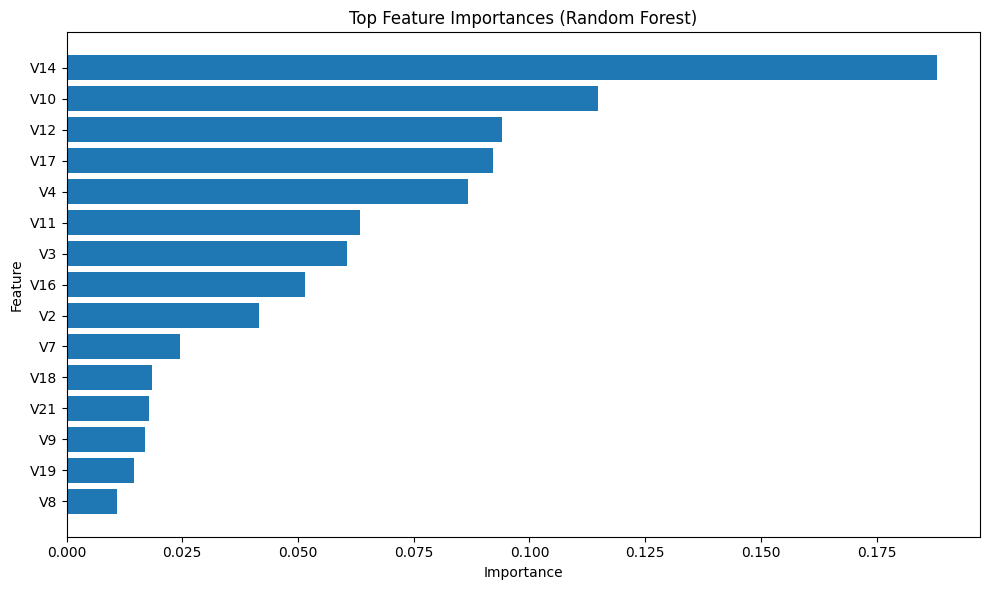

Saved plot as feature_importance.png


In [23]:
plt.figure(figsize=(10, 6))
top_n = 15
plt.barh(fi["feature"].head(top_n)[::-1], fi["importance"].head(top_n)[::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved plot as feature_importance.png")

In [24]:
from google.colab import files
files.download("best_fraud_model.pkl")
files.download("feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>